DEEPANSHU KUMAAR GIRI

22070126030

AIML A2

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ishaan2605","key":"6c4aad313719c52129eec4b474b57ad1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download CelebA dataset from Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

# Extract dataset
!unzip -q celeba-dataset.zip -d /content/CelebA


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:06<00:00, 223MB/s]
100% 1.33G/1.33G [00:06<00:00, 234MB/s]


In [ ]:
import os
print(os.listdir("/content/CelebA"))


['list_eval_partition.csv', 'list_bbox_celeba.csv', 'list_landmarks_align_celeba.csv', 'list_attr_celeba.csv', 'img_align_celeba']


In [ ]:
data_root = "/content/CelebA/img_align_celeba"


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# DATASET PREPARATION (CelebA in Colab)
data_root = "/content/CelebA/img_align_celeba"
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=os.path.dirname(data_root), transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Initialize models
gen = Generator(nz=100).to(device)
disc = Discriminator().to(device)


In [ ]:
# Loss & Optimizers
criterion = nn.BCELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# TRAINING LOOP
n_epochs = 10
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

for epoch in range(n_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optimizer_disc.zero_grad()
        output_real = disc(real_images).view(-1, 1)
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = gen(noise)
        output_fake = disc(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()
        optimizer_disc.step()

        # Train Generator
        optimizer_gen.zero_grad()
        output_fake = disc(fake_images).view(-1, 1)
        loss_gen = criterion(output_fake, real_labels)
        loss_gen.backward()
        optimizer_gen.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch}/{n_epochs}] | D Loss: {loss_real + loss_fake:.4f} | G Loss: {loss_gen:.4f}")

Epoch [0/10] | D Loss: 0.6363 | G Loss: 2.4219
Epoch [0/10] | D Loss: 0.4466 | G Loss: 4.8967
Epoch [0/10] | D Loss: 0.1580 | G Loss: 3.9584
Epoch [0/10] | D Loss: 0.3489 | G Loss: 3.5652
Epoch [0/10] | D Loss: 0.3080 | G Loss: 2.2862
Epoch [0/10] | D Loss: 0.5198 | G Loss: 2.9886
Epoch [0/10] | D Loss: 0.8799 | G Loss: 6.6087
Epoch [0/10] | D Loss: 0.2218 | G Loss: 3.4942
Epoch [0/10] | D Loss: 0.5031 | G Loss: 4.5386
Epoch [0/10] | D Loss: 0.1905 | G Loss: 3.3929
Epoch [0/10] | D Loss: 0.4591 | G Loss: 5.0250
Epoch [0/10] | D Loss: 0.2051 | G Loss: 3.0561
Epoch [0/10] | D Loss: 0.3111 | G Loss: 2.9704
Epoch [0/10] | D Loss: 1.3371 | G Loss: 0.9059
Epoch [0/10] | D Loss: 0.2257 | G Loss: 3.5791
Epoch [0/10] | D Loss: 0.4313 | G Loss: 2.6751
Epoch [0/10] | D Loss: 0.6341 | G Loss: 2.3064
Epoch [0/10] | D Loss: 0.2708 | G Loss: 3.2139
Epoch [0/10] | D Loss: 0.2011 | G Loss: 2.5138
Epoch [0/10] | D Loss: 0.2541 | G Loss: 4.1405
Epoch [0/10] | D Loss: 0.2915 | G Loss: 2.4551
Epoch [0/10] 

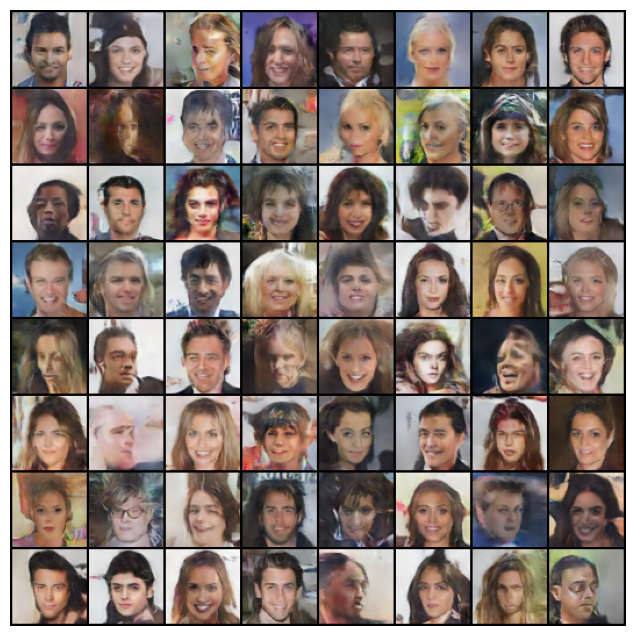

In [ ]:
# GENERATING FAKE IMAGES
def generate_images():
    gen.eval()
    noise = torch.randn(64, 100, 1, 1, device=device)
    with torch.no_grad():
        fake_images = gen(noise).cpu()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0)))
    plt.show()

generate_images()